Descomentar y correr estas 2 líneas solo una vez y luego borrarlas.

In [1]:
#!python -m spacy download es_core_news_sm

In [2]:
#!pip install itertools matplotlib networkx nltk numpy pandas pyplutchik spacy

# 1. Imports

Importación de las librerías necesarias para el funcionamiento del código.

In [3]:
from itertools import combinations
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import numpy as np
import pandas as pd
from pyplutchik import plutchik
import spacy

# 2. Obtención de los puntajes de las emociones en el texto

Función que permite extraer las emociones presentes en un texto, las cuales pueden ser la alegría, la confianza, el miedo, la sorpresa, la tristeza, la aversión, la ira y la anticipación, que corresponden a las 8 emociones básicas planteadas por Robert Plutchik.

In [4]:
from LexiMent import get_raw_emotion_scores

# *
# text: Texto que se analizará
# keys: Lista de emociones
# *
def get_emotions(text, keys):
    emo = get_raw_emotion_scores(text)    
    #print(emo)
    
    # Counts emotions occurrences (default is 0)
    emo = {key: int(emo[key] > 0) if key in emo else 0 for key in keys}
    #print(text)
    #print(emo)
    
    return emo

# 3. Lectura de los Tweets en un Excel

Función que permite leer un archivo de excel que contiene los Tweets a analizar. Esta recopilación de tweets se hizo de manera manual buscando comentarios con cieras palabras claves como "desigualdad", "inclusión", "violencia" entre otros; y se modificaron solo con el objetivo de eliminar hipervínculos y emojis.

In [5]:
from LexiMent import create_csv_from_tweets

# Ruta al archivo de Excel
excel_file_path = 'Tweets.xlsx'

# Lee el archivo de Excel en un DataFrame de pandas sin encabezados
df = pd.read_excel(excel_file_path, header=None)

# Convierte la primera columna del DataFrame en una lista
comments = df.iloc[:, 0].tolist()

#Función opcional para genrar 2 archivos .csv con el listado de palabras, emociones, y tipo de palabra.
#create_csv_from_tweets(comments)

# 4. [Gráfico 1] Rosa de Plutchik

La rueda de las emociones de Robert Plutchik es un recurso gráfico en forma de flor con ocho pétalos de diferentes colores, que muestra e identifica las diferentes emociones y las relaciones que se establecen entre ellas. La teoría de la rueda de las emociones se basa en los criterios de tipología, antagonismo e intensidad:

* Tipología: Las emociones se dividen en emociones básicas y compuestas.
* Antagonismo: Las emociones se encuentran situadas dependiendo de su grado de similitud y discrepancia; aquellas más similares están cercanas y las más antagónicas están en situación de oposición.
* Intensidad: Las emociones básicas presentan diferentes niveles de intensidad, lo que se ve reflejado en la fuerza de los colores de esta ruleta.

En este estudio **no se trabajó** con los grados de intensidad para simplificar el análisis, por lo que estos gráficos de Plutchick solo representan las emociones básicas recopiladas en los 117 Tweets obtenidos.

{'anger': 0.4700854700854701, 'anticipation': 0.39316239316239315, 'disgust': 0.36752136752136755, 'fear': 0.47863247863247865, 'joy': 0.2222222222222222, 'sadness': 0.4700854700854701, 'surprise': 0.15384615384615385, 'trust': 0.46153846153846156}


<Axes: >

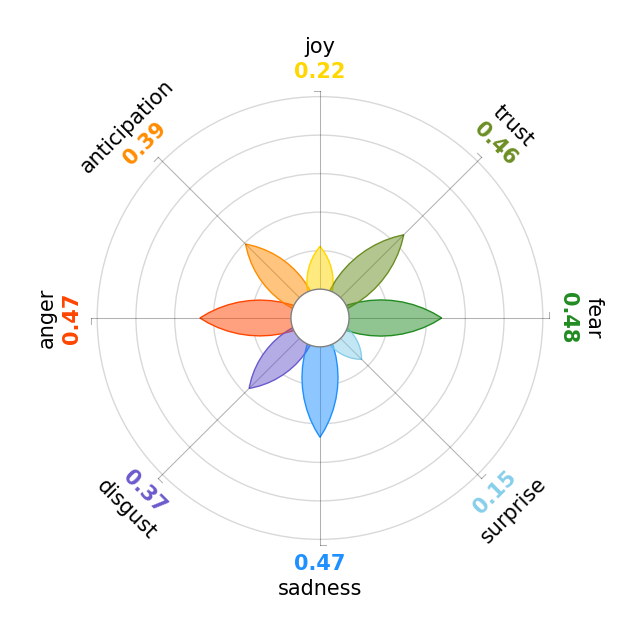

In [6]:
# Emotions
keys = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
# keys = ['enojo', 'anticipación', 'repugnancia', 'miedo', 'alegría', 'tristeza', 'sorpresa', 'confianza']

tmpscore = [get_emotions(post, keys) for post in comments]

#Ver como se distribuyeron las emociones en cada comentario (Primeros 5)
# i=0
# for aux in tmpscore[:5]:
#     print('{}: {}\n{}\n'.format(i+1, comment, aux))
#     i+=1

# Average scores 
scores = {key: np.mean([ts[key] for ts in tmpscore]) for key in keys}    
print(scores)

plutchik(scores)

# 5. [Gráfico 2] Rosa de Plutchik : Diadas Primarias

Plutchik indicó que los estados emocionales descritos albergaban cierta similitud entre ellos, lo que los hacía susceptibles de ser combinados de distintas maneras, culminando en la formación de un sentimiento más complejo. Se refirió a estos solapamientos como díadas; y las diferenció como primarias, secundarias o terciarias (cada vez menos frecuentes y bordadas por afectos con menor grado de parentesco).

La primera díada se compone de la combinación entre las emociones básicas que se encuentran al lado:

* Alegría + Confianza → Amor
* Alegría + Anticipación → Optimismo
* Confianza + Miedo → Sumisión
* Miedo + Sorpresa → Alarma
* Sorpresa + Tristeza → Decepción
* Tristeza + Asco → Remordimiento
* Asco + Ira→ Desprecio
* Ira + Anticipación → Agresión

Enfocamos la representación de las diadas primarias calculando el promedio de los valores de las emociones que las conforman.

<Axes: >

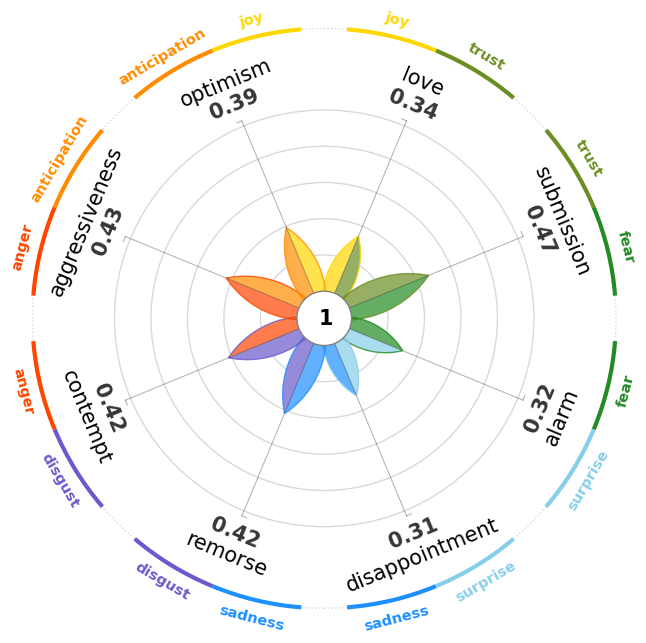

In [7]:
emotions = scores

love = (emotions["joy"] + emotions["trust"]) / 2
submission = (emotions["trust"] + emotions["fear"]) / 2
alarm = (emotions["fear"] + emotions["surprise"]) / 2
disappointment = (emotions["surprise"] + emotions["sadness"]) / 2
remorse = (emotions["sadness"] + emotions["disgust"]) / 2
contempt = (emotions["disgust"] + emotions["anger"]) / 2
aggressiveness = (emotions["anger"] + emotions["anticipation"]) / 2
optimism = (emotions["anticipation"] + emotions["anticipation"]) / 2

prymary_diads = {"love": love,
                 "submission" : submission,
                 "alarm": alarm,
                 "disappointment" : disappointment,
                 "remorse" : remorse,
                 "contempt": contempt,
                 "aggressiveness": aggressiveness,
                 "optimism": optimism}


plutchik(prymary_diads)

# 6. Creación de los Grafos

Para representar las relaciones entre las palabras, se utilizó el modelo de un grafo no dirigido, el cual consta de un conjunto de vértices que están conectados a un conjunto de aristas de forma no direccional.
Además con la ayuda de un lexicón de +5000 palabras en español y algunas técnicas de filtrado de texto, se logró reducir la cantidad de palabras totales, eliminando aquellas palabras sin significado propio, como por ejemplo, los artículos o las preposiciones. Esto, con el objetivo de enriquecer a la visualización solo con palabras que representen la idea central de cada tweet.

In [8]:
from LexiMent import get_lexicon

%matplotlib inline

# Cargar el modelo de lenguaje de spaCy
nlp = spacy.load("es_core_news_sm")

#Conjunto de palabras a utilizar
valsexpan = set(get_lexicon())

#Lista de relaciones a excluir:
excl_rel = ["det", "aux", "prep", "expl:pv", "case", "ROOT", "cc"]

#Lista de puntuaciones y isgnos a excluir
excl_punt_sign = ['.', ',', ':', ';', '¿', '?', '(', ')', '!', '¡','"']

#Lista de palabras junto con la cantidad de veces que aparece
count_words = {}

#Listas de grafos
graphpos = []
graphneg = []
graphcol = []

for text in comments:
    #Paso 1: Analizar el texto
    doc = nlp(text)

    #Pasos 2 y 3: Crear el grafo inicial
    reg = nx.Graph()
    for relacion in doc:
        if relacion.dep_ not in excl_rel: #Paso 2.1 Exluyo algunas relaciones (preposiciones, verbos auxiliares, entre otros)
            if relacion.text not in excl_punt_sign: #Excluyo signos de puntuación
                reg.add_edge(relacion.head.lemma_.lower(), relacion.lemma_.lower(), tipo=relacion.dep_) #Paso 2.2 Lemmatizar y Paso 3: Generar vertices/aristas del grafo
                if relacion.head.lemma_.lower() not in count_words:
                    count_words[relacion.head.lemma_.lower()] = 1
                else:
                    count_words[relacion.head.lemma_.lower()] = count_words[relacion.head.lemma_.lower()] + 1                

    #Paso 4: Obtener conjunto de nodos finales sin repetir
    ly0 = set(reg.nodes())

    #Paso 5: Palabras que están en ly0 y en valexpan
    wordsto = ly0.intersection(valsexpan)

    #Paso 6: Generar todas las combinaciones únicas de elementos en el conjunto
    couples = list(combinations(wordsto, 2))

    #Paso 7: Encontrar un path dentro del grafo entre cada par de nodos de la lista "couples"
    paths_total = []
    for node1, node2 in couples:
        try:
            paths_temp = nx.all_shortest_paths(reg, source=node1, target=node2)
            for path in paths_temp:
                paths_total.append(path)
        except nx.NetworkXNoPath:
            continue

    #Paso 8: Crear lista solo con los path de longitud igual o menor a 3
    paths = [path for path in paths_total if len(path) <=3]

    #Paso 9: Almaceno aquellos path que no tienen la palabara "no"
    affpath = [p for p in paths if 'no' not in p]

    #Paso 10: Almaceno aquellos path que tienen la palabara "no"
    negpath = [p for p in paths if 'no' in p]

    #Paso 11: De los path "positivos", guardo solo el nodo inicial y final de cada path
    affsemlin = [(path[0], path[-1]) for path in affpath]

    #Paso 12: De los path "negativos", guardo solo el nodo inicial y final de cada path
    negsemlin = [(path[0], path[-1]) for path in negpath]

    #Paso 13: Generar un grafo donde los nodos sean wordsto y los enlaces sean de affsemlin
    afntw = nx.DiGraph()
    # Agregar nodos
    for palabra in wordsto:
        afntw.add_node(palabra)

    # Agregar enlaces basados en nodos iniciales y finales
    for inicio, final in affsemlin:
        if inicio in wordsto and final in wordsto:
            afntw.add_edge(inicio, final)

    #Paso 14: Generar un grafo donde los nodos seann wordsto y los enlaces sean de negsemlin
    nentw = nx.DiGraph()
    # Agregar nodos
    for palabra in wordsto:
        nentw.add_node(palabra)

    # Agregar enlaces basados en nodos iniciales y finales
    for inicio, final in negsemlin:
        if inicio in wordsto and final in wordsto:
            nentw.add_edge(inicio, final)

    #Paso 15: Generar un grafo donde los nodos seann wordsto y los enlaces sean de affsemlin + negsemlin
    totsemlin = affsemlin + negsemlin
    totntw = nx.DiGraph()
    # Agregar nodos
    for palabra in wordsto:
        totntw.add_node(palabra)

    # Agregar enlaces basados en nodos iniciales y finales
    for inicio, final in totsemlin:
        if inicio in wordsto and final in wordsto:
            totntw.add_edge(inicio, final)
    
    #Paso final del bucle: Agrego cada grafo final a una lista de grafos
    graphpos.append(afntw)
    graphneg.append(nentw)
    graphcol.append(totntw)

# 7. [Gráfico 3] Grafo de Relaciones simple

Grafo que permite observar la relación entre las palabras obtenidas de los 117 Tweets luego de un proceso de filtrado.

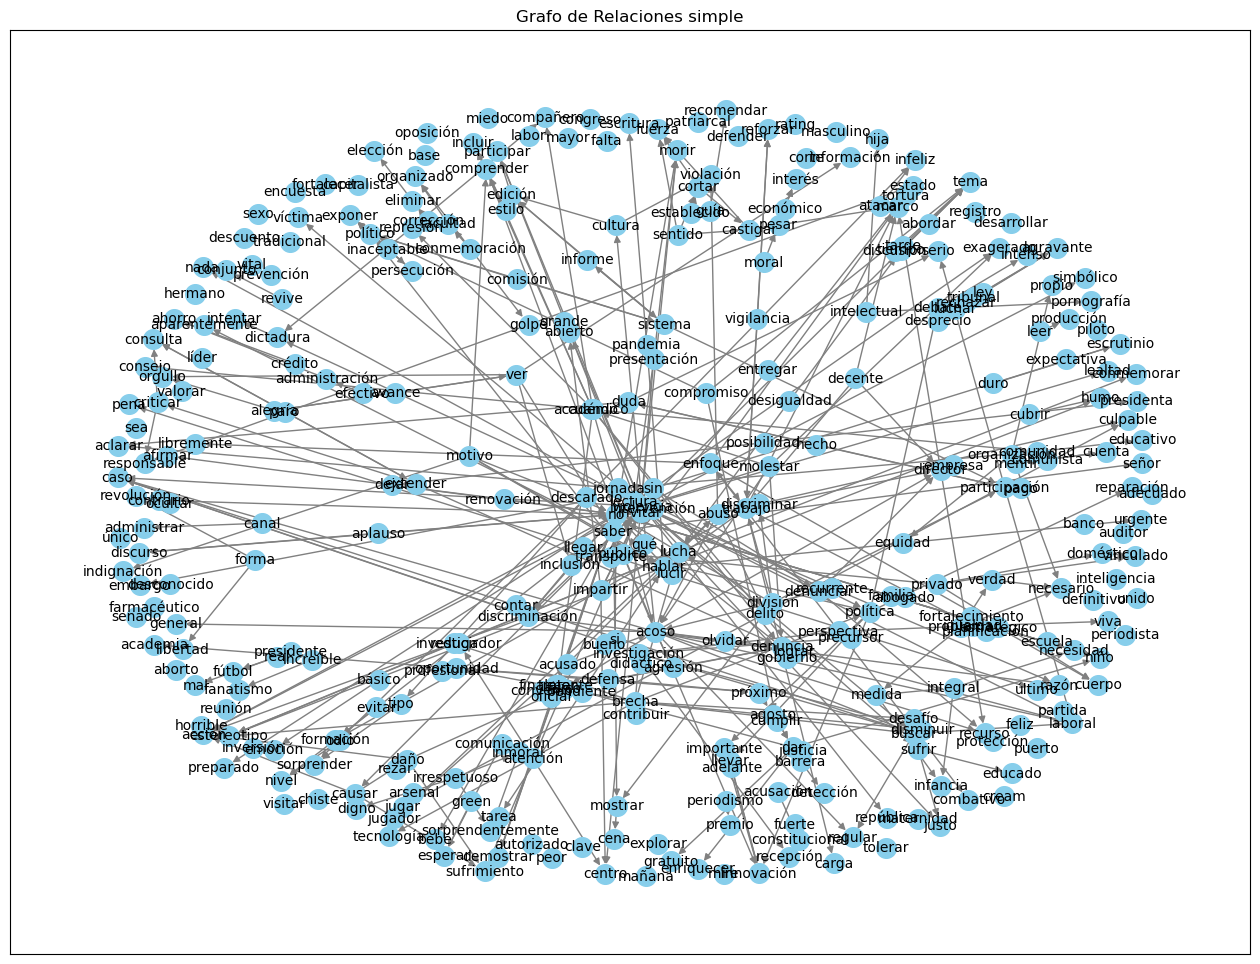

In [9]:
from LexiMent import get_list_polarity

#Lista de palabras según si polaridad (Negatva, Positiva y Neutra)
neg2 = get_list_polarity("negative")
pos2 = get_list_polarity("positive")
neu2 = get_list_polarity("neutro")

#Paso 16: Crear el grafo final (Vértices = todos los vértices de cada grafo de graphcol, aristas = todas las aristas de cada grafo de graphcol)
gmer = nx.compose_all(graphcol)

#Visualizar el grafo en Jupyter Notebook
#pos = nx.circular_layout(gmer) #Visualización Circular
pos = nx.spring_layout(gmer) #Visualización "Normal"
labels = {n: n for n in gmer.nodes()}

plt.figure(figsize=(16, 12))
nx.draw_networkx(gmer, pos, with_labels=True, labels=labels, node_size=200, node_color="skyblue", font_size=10, font_color="black", edge_color="gray")
plt.title("Grafo de Relaciones simple")
plt.show()

# 8. [Gráfico 4] Grafo de Relaciones Reducido, Coloreado y Personalizado

Este grafo es una mejora al anterior, el cual tiene la particularidad de estar coloreado lo que permite una mejor visualización de la importancia de las palabras.
* Color de las palabras:
    * Rojo: Palabra catalogada como negativa.
    * Azul: Palabra catalogada como positiva
    * Negro: Palabra catalogada como neutra.


* Color de la relación:
    * Rojo: Conexión entre una palabra "negativa" a otra "negativa"
    * Azul: Conexión entre una palabra "positiva" a otra "positiva"
    * Púrpura: Conexión entre una palabra "negativa" a otra "positiva" o viceversa.
    * Gris: Conexión entre una palabra "neutra" a cualquier otra palabra.
    
Además, cuenta con una "potenciación" de aquellas palabras que mas veces se repiten en los Tweets, haciendo que se resalten del resto al tener un tamaño de letra mayor. Es decir, mientras mas veces aparezca una palabra en los textos, mas grande será su tamaño en el grafo.

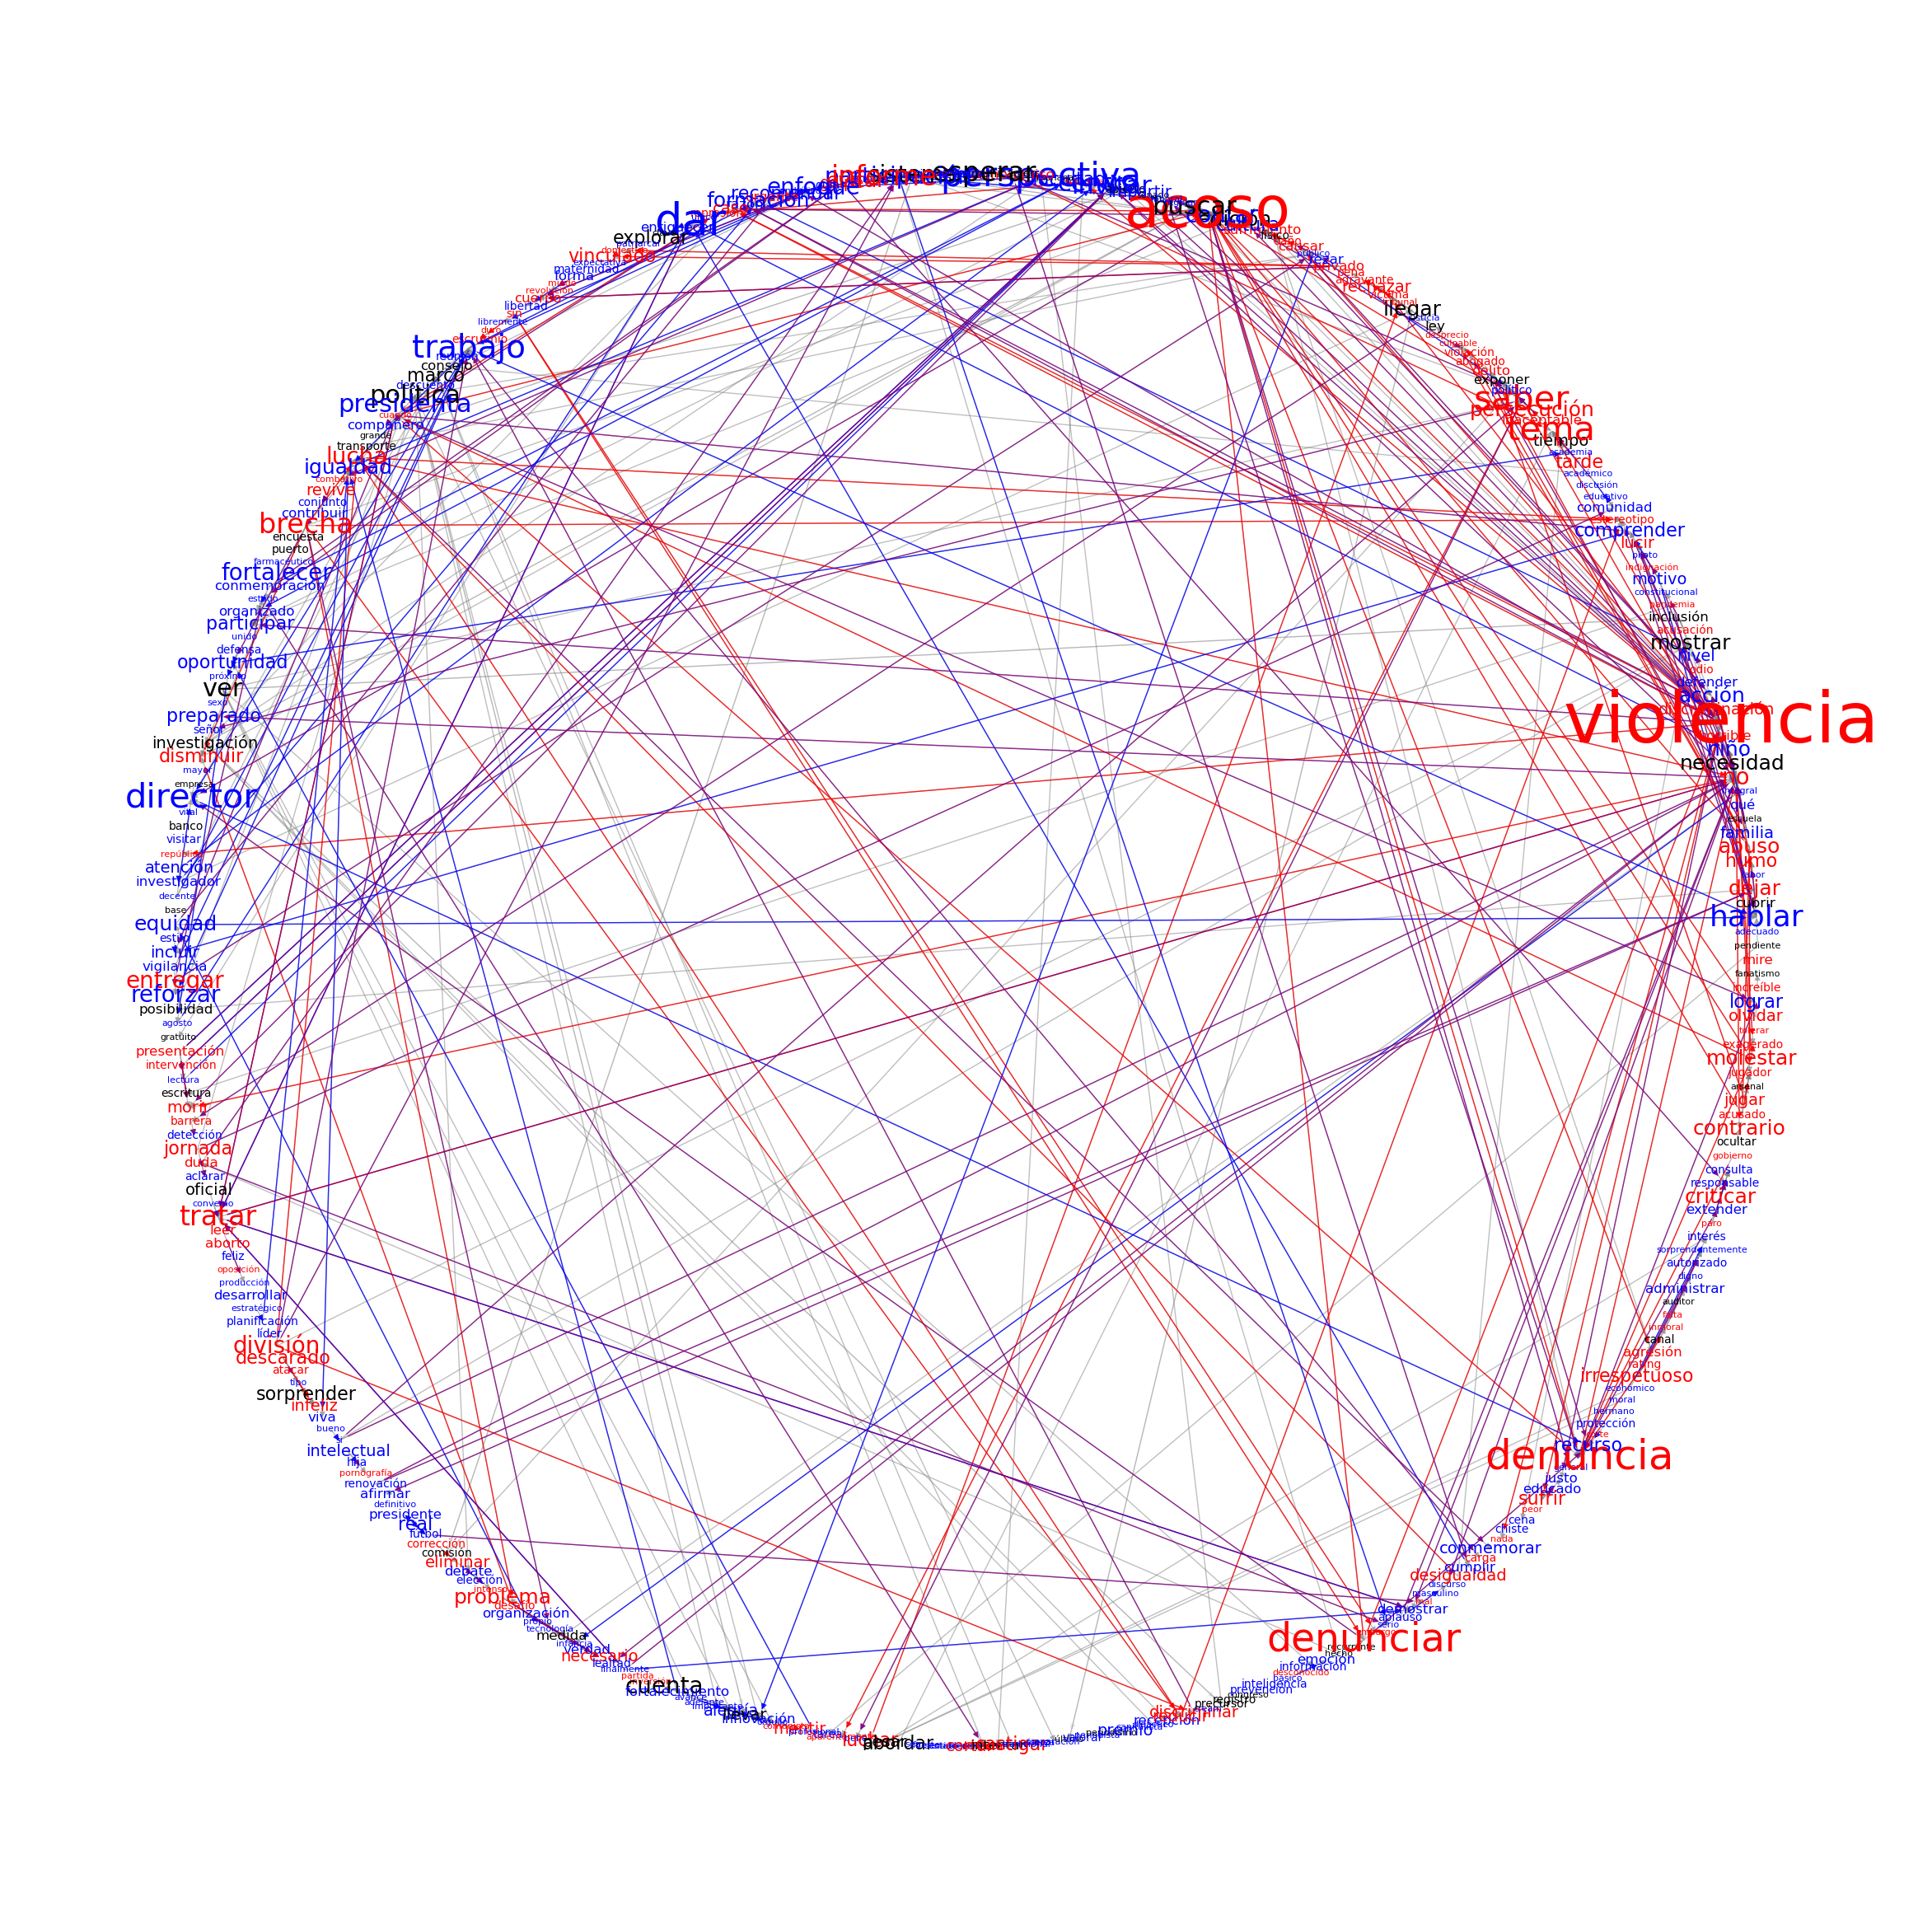

In [10]:
#Paso 17: Trabajo futuro -> Generar grafo de sinónimos

# #Paso 18 y 19: Definir color azul y purpura (en caso de querer personalizar colores)
# color1 = (0.01, 0.5, 1) #Azul
# color2 = (0.95, 0.1, 0.05) #Púrpura

#Paso 20: Definir función que personaliza los textos (etiquetas)
def panel_label(lbl):
    count = 0
    if lbl in count_words:
        count = count_words[lbl]
    if lbl == "no":
        return {'label': lbl, 'color': 'red', 'font_size': 20}
    elif lbl in neg2:
        return {'label': lbl, 'color': 'red', 'font_size': (8 + 2*count)}
    elif lbl in pos2:
        return {'label': lbl, 'color': 'blue', 'font_size': (8 + 2*count)}
    else:
        return {'label': lbl, 'color': 'black', 'font_size': (8 + 2*count)}

#Paso 21: Almaceno las aristas del grafo final
e1 = gmer.edges()

#Paso 22: Almaceno las aristas del grafo final que van de palabra negativa a palabra negativa
negneg = [edge for edge in e1 if edge[0] in neg2 and edge[1] in neg2]
#print(negneg)

#Paso 23: Almaceno las aristas del grafo final que van de palabra positiva a palabra positiva
pospos = [edge for edge in e1 if edge[0] in pos2 and edge[1] in pos2]
#print(pospos)

#Paso 24: Almaceno las aristas del grafo final que van de palabra neutra a palabra neutra
neuneu = [edge for edge in e1 if edge[0] in neu2 and edge[1] in neu2]
#print(neuneu)

#Paso 25: Almaceno las aristas del grafo final que van de palabra positiva a palabra negativa o al revés
negpos = [edge for edge in e1 if ((edge[0] in neg2 and edge[1] in pos2) or (edge[0] in pos2 and edge[1] in neg2))]
#print(negpos)


# Crear el grafo og
og = nx.Graph()
og = gmer
pos = nx.circular_layout(og) #Grafo Circular
#pos = nx.spring_layout(og) #Grafo Normal

# Crear el dibujo del grafo
fig, ax = plt.subplots(figsize=(30, 30))


# Dibujar nodos
for node, (x, y) in pos.items():
    ax.scatter(x, y, s=0)
    label_attrs = panel_label(node)
    ax.text(x, y, label_attrs['label'], color=label_attrs['color'], fontsize=label_attrs['font_size'],
            ha='center', va='center')

# Dibujar aristas con diferentes atributos
nx.draw(og, pos, ax=ax, node_size=0, width=1, alpha=0.5, edge_color='gray')

for e in neuneu:
    nx.draw_networkx_edges(og, pos, edgelist=[e], ax=ax, edge_color='gray', alpha=0.1, width=1)

for e in negneg:
    nx.draw_networkx_edges(og, pos, edgelist=[e], ax=ax, edge_color='red', alpha=0.8, width=1)

for e in pospos:
    nx.draw_networkx_edges(og, pos, edgelist=[e], ax=ax, edge_color='blue', alpha=0.8, width=1)

for e in negpos:
    nx.draw_networkx_edges(og, pos, edgelist=[e], ax=ax, edge_color='purple', alpha=0.8, width=1)

# Eliminar ejes
ax.set_xticks([])
ax.set_yticks([])

# Mostrar el gráfico
plt.show()


# 9. [Gráfico 5] Algoritmo de Louvain

El algoritmo de Louvain se emplea en la detección de comunidades dentro de conjuntos de datos. Este algoritmo se utiliza para identificar la comunidad más grande y conectada en un grafo, lo que permite eliminar nodos (en este caso, palabras) que no formen parte de esta comunidad. Este proceso de eliminación contribuye a simplificar la visualización del grafo, mejorando la comprensión de la estructura de la red.

Grafo inicial con 349 nodos y 409 conexiones
Número de comunidades detectadas: 78
Cantidad de nodos en la comunidad mas grande :  231


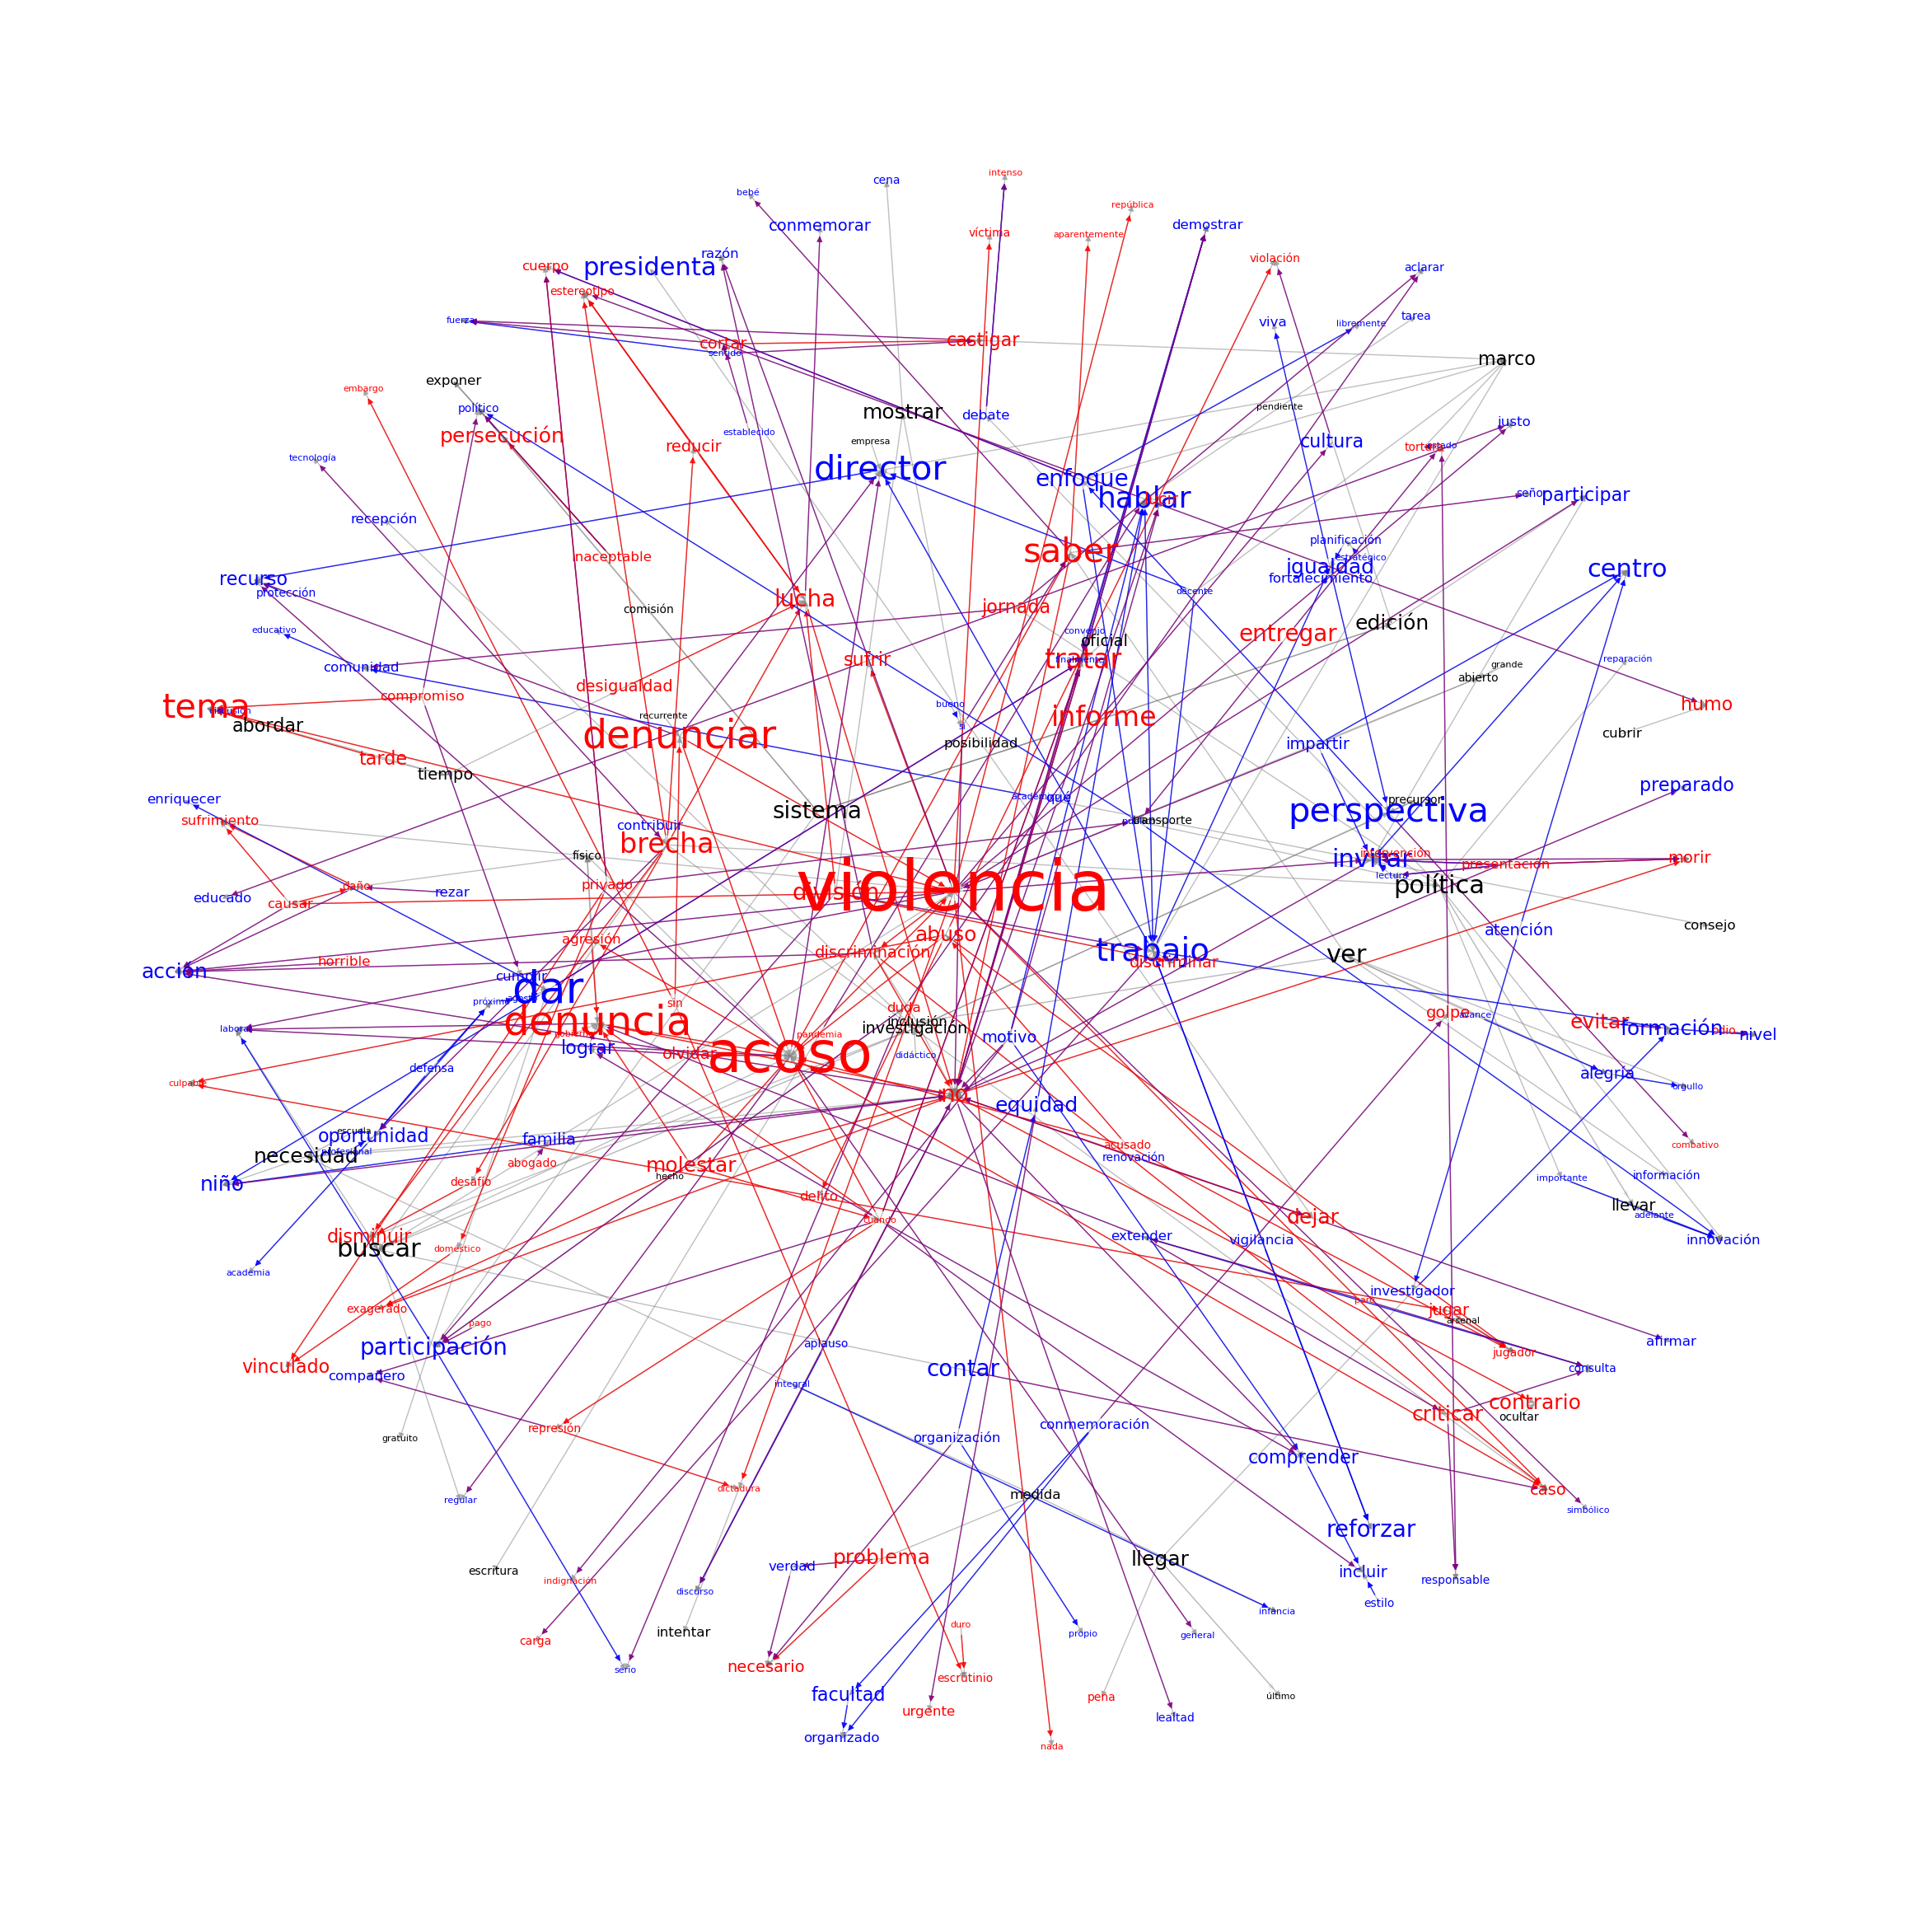

In [11]:
import networkx.algorithms.community as nx_comm
import matplotlib.colors as mcolors

G = gmer
#pos = nx.circular_layout(G) #Grafo Circular
pos = nx.spring_layout(G) #Grafo Normal
print("Grafo inicial con {0} nodos y {1} conexiones".format(len(G.nodes()), len(G.edges())))

communities = nx_comm.louvain_communities(G, resolution=0, seed=123)
#print(communities)
print(f"Número de comunidades detectadas: {len(communities)}")
#print(f"Tamaño de las comunidades detectadas: {[len(comunidad) for comunidad in communities]}")


#---------------------------- Graficar todos los subgrafos --------------------------
# communities_map = {}
# for i in range(len(communities)):
#     communities_map.update(dict.fromkeys(communities[i], i))
    
# color_pallet = list(mcolors.TABLEAU_COLORS.values())*20 #Cantidad por defecto: 10
# node_colors = []
# for node in G:
#     node_colors.append(color_pallet[communities_map[node]])

# fig, ax = plt.subplots(figsize=(20, 20))
# nx.draw(G, ax=ax, node_color=node_colors, with_labels=True)
# plt.show()

#--------------------------- Graficar el grafo mas conectado ------------------------

# Encuentras la comunidad más grande
largest_community = max(communities, key=len)
print("Cantidad de nodos en la comunidad mas grande : ", len(largest_community))

# Creas un nuevo grafo solo con los nodos de la comunidad más grande
largest_community_subgraph = G.subgraph(largest_community)

# Crear el grafo og
nog = nx.Graph()
nog = largest_community_subgraph
#pos = nx.circular_layout(nog) #Grafo Circular
pos = nx.spring_layout(nog) #Grafo Normal

# Crear el dibujo del grafo
fig, ax = plt.subplots(figsize=(30, 30))


# Dibujar nodos
for node, (x, y) in pos.items():
    ax.scatter(x, y, s=0)  # Dibujar nodo invisible
    label_attrs = panel_label(node)
    ax.text(x, y, label_attrs['label'], color=label_attrs['color'], fontsize=label_attrs['font_size'],
            ha='center', va='center')

# Dibujar aristas con diferentes atributos
nx.draw(nog, pos, ax=ax, node_size=0, width=1, alpha=0.5, edge_color='gray')

for e in neuneu:
    if e[0] in nog.nodes() and e[1] in nog.nodes() :
        nx.draw_networkx_edges(nog, pos, edgelist=[e], ax=ax, edge_color='gray', alpha=0.1, width=1)

for e in negneg:
    if e[0] in nog.nodes() and e[1] in nog.nodes() :
        nx.draw_networkx_edges(nog, pos, edgelist=[e], ax=ax, edge_color='red', alpha=0.8, width=1)

for e in pospos:
    if e[0] in nog.nodes() and e[1] in nog.nodes() :
        nx.draw_networkx_edges(nog, pos, edgelist=[e], ax=ax, edge_color='blue', alpha=0.8, width=1)

for e in negpos:
    if e[0] in nog.nodes() and e[1] in nog.nodes() :
        nx.draw_networkx_edges(nog, pos, edgelist=[e], ax=ax, edge_color='purple', alpha=0.8, width=1)

# for e in gsyn.edges():
#     nx.draw_networkx_edges(og, pos, edgelist=[e], ax=ax, edge_color='green', alpha=0.8, width=0.018)

# Eliminar ejes
ax.set_xticks([])
ax.set_yticks([])

# Mostrar el gráfico
plt.show()

# 10. Generación de Archivos con nodos y relaciones finales

In [12]:
import csv
nodos = list(nog.nodes())
with open('Nodos_Finales.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Nodo', 'Polaridad', '#Veces_Aparece'])  # Encabezado
    for nodo in G.nodes():
        polaridad = "neutro"
        contador = 1
        if nodo in count_words:
            contador = count_words[nodo]
        if nodo in neg2:
            polaridad = "negativo"
        elif nodo in pos2:
            polaridad = "positivo"
        writer.writerow([nodo, polaridad, contador])

In [13]:
import csv
relaciones = list(nog.edges())
with open('Relaciones_Finales.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['NodoInicio', 'NodoFin'])  # Encabezado
    writer.writerows(relaciones)